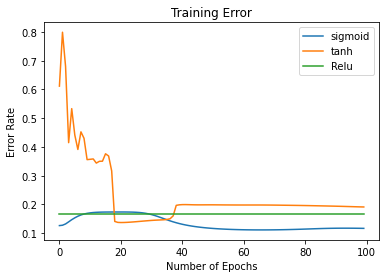

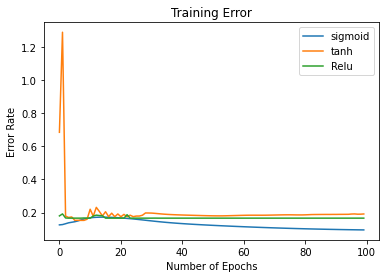

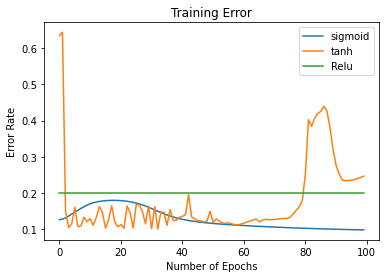

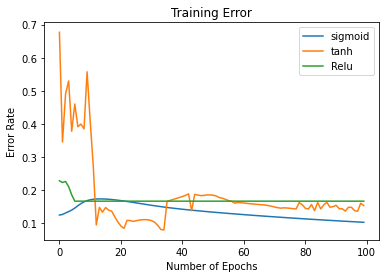

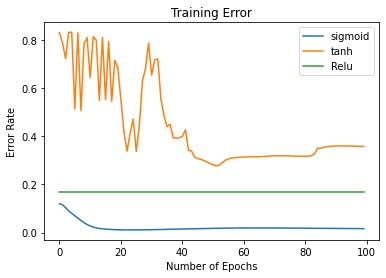

Scores: [17.81609195402299, 22.413793103448278, 19.54022988505747, 20.689655172413794, 16.666666666666664]
Mean Accuracy: 19.425%


In [5]:
# Backprop on the Seeds Dataset
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp
import matplotlib.pyplot as plt

def mean_squared_error(expected,actual):
    summation = 0
    for i in range(len(expected)):
        summation  =summation + ((expected[i] - actual[i])*(expected[i] - actual[i]))
    return  summation/len(expected)

# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

# Find the min and max values for each column
def dataset_minmax(dataset):
    minmax = list()
    stats = [[min(column), max(column)] for column in zip(*dataset)]
    return stats

# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)-1):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

# Calculate neuron activation for an input
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

# Transfer neuron activation
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))

# Forward propagate input to a network output
def forward_propagate(network, row,ativations,key):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = ativations[key](activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

# Calculate the derivative of an neuron output
def transfer_derivative(output):
    return output * (1.0 - output)

# Backpropagate error and store in neurons
def backward_propagate_error(network, expected,derivative_of_activations,key):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * derivative_of_activations[key](neuron['output'])

# Update network weights with error
def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += l_rate * neuron['delta']

# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
    ativations = {
         'sigmoid': (lambda x: 1/(1 + exp(-x))),
            'tanh': (lambda x: (exp(x) - exp(-x))/(exp(x) + exp(-x))),
            'Relu': (lambda x: x*(x > 0)),
               }
    derivative_of_activations = {
         'sigmoid': (lambda x: x*(1-x)),
            'tanh': (lambda x: 1-x**2),
            'Relu': (lambda x: 1 * (x>0))
               }
    for key in ativations:
        epoch_array = list()
        error_array = list()
        for epoch in range(n_epoch):
            for row in train:
                outputs = forward_propagate(network, row,ativations,key)
                expected = [0 for i in range(n_outputs)]
                expected[row[-1]] = 1
                backward_propagate_error(network, expected,derivative_of_activations,key)
                update_weights(network, row, l_rate)
            epoch_array.append(epoch)
            current_error = mean_squared_error(outputs,expected)
            error_array.append(current_error)
        plt.plot(epoch_array,error_array,label = key)
    plt.title("Training Error")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Error Rate")
    plt.legend(loc='best')
    plt.show()
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = list()
    hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer)
    output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network

# Make a prediction with a network
def predict(network, row):
    ativations = {
         'sigmoid': (lambda x: 1/(1 + exp(-x))),
            'tanh': (lambda x: (exp(x) - exp(-x))/(exp(x) + exp(-x))),
            'Relu': (lambda x: x*(x > 0)),
               }
    derivative_of_activations = {
         'sigmoid': (lambda x: x*(1-x)),
            'tanh': (lambda x: 1-x**2),
            'Relu': (lambda x: 1 * (x>0))
               }
    outputs = forward_propagate(network, row,ativations,"sigmoid")
    return outputs.index(max(outputs))

# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    network = initialize_network(n_inputs, n_hidden, n_outputs)
    train_network(network, train, l_rate, n_epoch, n_outputs)
    predictions = list()
    for row in test:
        prediction = predict(network, row)
        predictions.append(prediction)
    return(predictions)

# Test Backprop on Seeds dataset
seed(1)
# load and prepare data
filename = "./data.csv"
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
    str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# normalize input variables
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
# evaluate algorithm
n_folds = 5
l_rate = 0.3
n_epoch = 100
n_hidden = 5

scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))